In [1]:
import numpy as np
import torch
from tqdm import tqdm
from matplotlib import pyplot as plt
import clip
import open_clip

import utils
import data_utils

from torch.utils.data import DataLoader, TensorDataset
from glm_saga.elasticnet import IndexedTensorDataset, glm_saga

In [2]:
device = "cuda"
dataset_name = "imagenet_val"
batch_size = 256
save_dir = 'saved_activations'
clip_name = "ViT-L-16-SigLIP-384"#"ViT-B/16"#"ViT-L/14@336px"#
openclip = True
concept_set = "data/20k.txt"#"data/combined_concepts.txt"#"data/20k.txt"
target_name = "resnet50"
target_layer = "layer4"
target_neuron = 2

if openclip:
    clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(clip_name.split("_")[-1], pretrained="webli",
                                                                       device=device)
else:
    clip_model, clip_preprocess = clip.load(clip_name, device=device)

model, preprocess = data_utils.get_target_model(target_name, device=device)

In [3]:
dataset = data_utils.get_data(dataset_name, preprocess)
clip_data = data_utils.get_data(dataset_name, clip_preprocess)

In [4]:
clip_save_name = "{}/{}_{}.pt".format(save_dir, dataset_name, clip_name.replace('/', ''))
utils.save_clip_image_features(clip_model, clip_data, clip_save_name, batch_size, device)
clip_image_features = torch.load(clip_save_name, map_location=device).float()

In [5]:
with open(concept_set, 'r') as f: 
    text = (f.read()).split('\n')
if openclip:
    tokenized_text = open_clip.get_tokenizer(clip_name.split("_")[-1])(text).to(device)
else:
    tokenized_text = clip.tokenize(text).to(device)
    avg_emb_path = "{}/20k_avg_{}.pt".format(save_dir, clip_name.replace("/", ""))
    avg_text_emb = utils.save_clip_avg_20k(clip_model, avg_emb_path, batch_size=1000, device=device)

text_save_name = "{}/{}_{}.pt".format(save_dir, concept_set.split("/")[-1].split(".")[0], clip_name.replace('/', ''))
clip_text_features = utils.get_clip_text_features(clip_model, tokenized_text).float()

In [6]:
a = utils.SIGMOID_PARAMS[clip_name]["a"]
b = -0.08#utils.SIGMOID_PARAMS[clip_name]["b"]#-0.08

with torch.no_grad():
    clip_image_features /= clip_image_features.norm(dim=-1, keepdim=True)
    clip_text_features /= clip_text_features.norm(dim=-1, keepdim=True)
    if openclip:
        clip_feats = clip_image_features @ (clip_text_features).T
    else:
        clip_feats = (clip_image_features @ (clip_text_features-avg_text_emb).T)
    clip_feats = torch.nn.functional.sigmoid(a*(clip_feats+b))

print(clip_feats.shape)
print(torch.mean(torch.sum(clip_feats, dim=1)))

torch.Size([50000, 20000])
tensor(24.1655, device='cuda:0')


In [7]:
mean_text = torch.mean(clip_feats, dim=0)
std_text = torch.std(clip_feats, dim=0)
print(mean_text, mean_text.shape)
vals, ids = torch.sort(mean_text, descending=True)
for id in ids[:20]:
    print(text[id], mean_text[id].cpu(), std_text[id].cpu())

tensor([2.9630e-04, 3.7066e-04, 1.0119e-04,  ..., 5.1425e-03, 3.9013e-04,
        7.1202e-05], device='cuda:0') torch.Size([20000])
canine tensor(0.0403) tensor(0.1149)
fauna tensor(0.0360) tensor(0.0820)
dog tensor(0.0323) tensor(0.0964)
cao tensor(0.0309) tensor(0.0787)
pas tensor(0.0287) tensor(0.0688)
tier tensor(0.0273) tensor(0.0601)
dogs tensor(0.0264) tensor(0.0851)
mammals tensor(0.0254) tensor(0.0875)
has tensor(0.0244) tensor(0.0455)
cleaned tensor(0.0236) tensor(0.0562)
beg tensor(0.0234) tensor(0.0474)
cane tensor(0.0230) tensor(0.0687)
breeds tensor(0.0229) tensor(0.0646)
breed tensor(0.0226) tensor(0.0693)
headed tensor(0.0221) tensor(0.0521)
adorable tensor(0.0221) tensor(0.0616)
sont tensor(0.0208) tensor(0.0370)
puppy tensor(0.0205) tensor(0.0773)
lai tensor(0.0205) tensor(0.0488)
breeding tensor(0.0204) tensor(0.0592)


In [8]:
vals, ids = torch.sort(std_text, descending=False)
for id in ids[0:20]:
    print(text[id], mean_text[id].cpu(), std_text[id].cpu())

replied tensor(5.9613e-07) tensor(3.4448e-05)
pdf tensor(4.3716e-06) tensor(5.2867e-05)
qr tensor(1.3659e-05) tensor(5.5669e-05)
notion tensor(1.5099e-06) tensor(5.9298e-05)
summarizes tensor(7.5288e-06) tensor(6.4456e-05)
commented tensor(1.2208e-06) tensor(6.4533e-05)
nominate tensor(1.9592e-06) tensor(7.0839e-05)
subscribe tensor(2.5358e-06) tensor(7.0934e-05)
jira tensor(5.5848e-06) tensor(7.1355e-05)
bootstrap tensor(2.1739e-06) tensor(7.5930e-05)
angular tensor(3.7918e-06) tensor(7.7881e-05)
enroll tensor(2.4107e-06) tensor(8.0475e-05)
among tensor(1.4287e-05) tensor(8.5099e-05)
postgresql tensor(7.8472e-06) tensor(8.9804e-05)
invoked tensor(5.9537e-06) tensor(9.4249e-05)
zelda tensor(1.4433e-05) tensor(9.4588e-05)
signup tensor(3.1463e-06) tensor(9.8648e-05)
namely tensor(1.5143e-06) tensor(0.0001)
origin tensor(7.4093e-06) tensor(0.0001)
steam tensor(3.7945e-06) tensor(0.0001)


## Deleting concepts that are not active on the dataset

In [9]:
active_concepts = std_text>0.001
clip_feats = clip_feats[:, active_concepts]
text = [concept for i, concept in enumerate(text) if active_concepts[i]]
print(len(text), clip_feats.shape)

mean_text = mean_text[active_concepts]
std_text = std_text[active_concepts]

18596 torch.Size([50000, 18596])


In [10]:
print(mean_text[text.index("yellow")])
pil_data = data_utils.get_data(dataset_name)

tensor(0.0017, device='cuda:0')


archbishop tensor(0.9852)
bishops tensor(0.9506)
doctorate tensor(0.9352)
bishop tensor(0.8982)
clergy tensor(0.8706)
chancellor tensor(0.8390)
anglican tensor(0.8353)
blessing tensor(0.8174)
judges tensor(0.7957)
sworn tensor(0.7564)
priests tensor(0.7227)
presiding tensor(0.6573)
cardinal tensor(0.6571)
ordination tensor(0.6339)
elders tensor(0.6295)
graduated tensor(0.6264)
pope tensor(0.6252)
examining tensor(0.6005)
commencement tensor(0.5973)
episcopal tensor(0.5792)


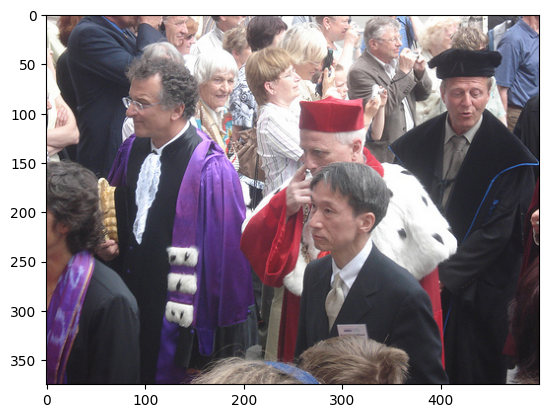

In [11]:
img_id = 20000

plt.imshow(pil_data[img_id][0])
vals, ids = torch.sort(clip_feats[img_id], descending=True)
for id in ids[:20]:
    print(text[id], clip_feats[img_id, id].cpu())

In [12]:
#size_by_layer = {"layer1":256, "layer2":512, "layer3":1024, "layer4":2048}
#target_neurons = range(size_by_layer[target_layer])
#for target_neuron in target_neurons:

neuron_save_path = '{}/{}_{}/{}/{}'.format(save_dir, target_name, dataset_name, target_layer, target_neuron)
activations = utils.save_activations(model, dataset, device, target_layer, target_neuron, batch_size, neuron_save_path)
summary_activations = activations.mean(dim=[1,2]).unsqueeze(1)
del clip_image_features, clip_text_features, activations
torch.cuda.empty_cache()

In [13]:
train_data = clip_feats#[:45000]
#val_data = clip_feats[45000:]
del clip_feats
torch.cuda.empty_cache()

In [14]:
with torch.no_grad():
    train_mean = torch.mean(train_data, dim=0, keepdim=True)
    train_std = torch.std(train_data, dim=0, keepdim=True)
    #print(train_mean, train_std)
    train_data -= train_mean
    train_data /= train_std

    target_mean = torch.mean(summary_activations)
    target_std = torch.std(summary_activations)
    #print(target_mean, target_std)
    train_target = (summary_activations-target_mean)/target_std
    
    indexed_train_ds = IndexedTensorDataset(train_data, train_target)

    
    #val_data -= train_mean
    #val_data /= train_std

    val_ds = TensorDataset(train_data, train_target)

In [15]:
saga_batch_size = 256
n_iters = 1000
lam = 3e-2#7e-2#5e-2#3e-2

indexed_train_loader = DataLoader(indexed_train_ds, batch_size=saga_batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=saga_batch_size, shuffle=False)

linear = torch.nn.Linear(in_features = train_data.shape[1], out_features = 1).to(device)
linear.weight.data.zero_()
linear.bias.data.zero_()

STEP_SIZE = 1e-4#7e-4#1e-4#3e-5
ALPHA = 0.99
metadata = {}
metadata['max_reg'] = {}
metadata['max_reg']['nongrouped'] = lam

output_proj = glm_saga(linear, indexed_train_loader, STEP_SIZE, n_iters, ALPHA, epsilon=1, k=1,
                      val_loader=val_loader, n_ex=len(train_data), do_zero=False, metadata=metadata, n_classes = 1, family='gaussian',
                       lookbehind=10, tol=1e-5)

W_g = output_proj['path'][0]['weight']
b_g = output_proj['path'][0]['bias']

 33%|█████████████████████████▊                                                     | 326/1000 [02:15<04:41,  2.40it/s]

obj 0.4240994155406952 weight nnz 236/18596 (0.0127) obj_best 0.42410704493522644 [early stop at 326]


(0) lambda 0.0303, loss 0.4241 [val loss 0.4241] [test loss -1.0000], sparsity 0.012690901269090126 [236/18596], time 136.47307896614075, lr 0.0001


In [16]:
linear.load_state_dict({"weight":W_g, "bias":b_g})
simulated = linear(train_data)*target_std + target_mean

In [17]:
vals, ids = torch.sort(W_g[0], descending=True)
print(ids.shape)
for i, id in enumerate(ids[:9]):
    print(text[id], vals[i])

torch.Size([18596])
researcher tensor(0.0623)
anglo tensor(0.0520)
wed tensor(0.0453)
ducks tensor(0.0441)
practitioner tensor(0.0434)
wedding tensor(0.0433)
victorian tensor(0.0424)
bees tensor(0.0379)
lotion tensor(0.0354)


In [18]:
loss_fn = torch.nn.MSELoss()
print("Loss:{:.4f}".format(loss_fn(simulated, summary_activations)))
corr_coefficient = np.corrcoef(summary_activations[:, 0].cpu(), simulated[:, 0].cpu().detach())[0, 1]
print("Correlation: {:.3f}".format(corr_coefficient))

Loss:0.1491
Correlation: 0.547


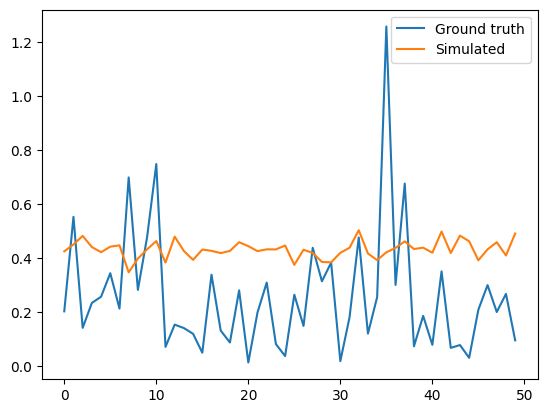

In [19]:
plt.plot(summary_activations[:50].cpu(), label="Ground truth")
plt.plot(simulated[:50].cpu().detach(), label="Simulated")
plt.legend()

y = 0.212x + 0.381


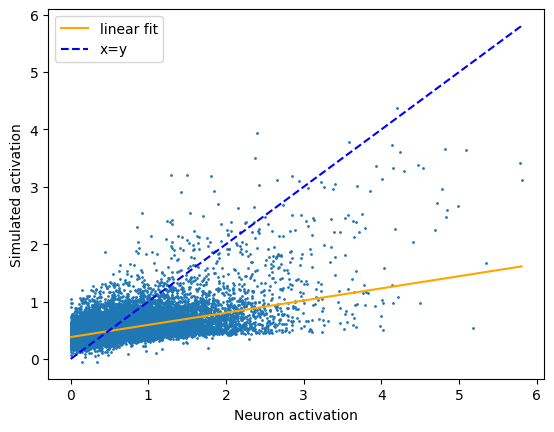

In [20]:
slope, intercept = np.polyfit(summary_activations[:, 0].cpu(), simulated[:,0].cpu().detach(), 1)
print("y = {:.3f}x + {:.3f}".format(slope, intercept))

x = np.array([0.001*i for i in range(int(torch.max(summary_activations)*1000))])
y_fit = slope * x + intercept

plt.scatter(summary_activations.cpu(), simulated.cpu().detach(), s=1)
plt.plot(x, y_fit, color='orange', label="linear fit")
plt.plot(x, x, "b--", label="x=y")
plt.xlabel("Neuron activation")
plt.ylabel("Simulated activation")
plt.legend()
pass

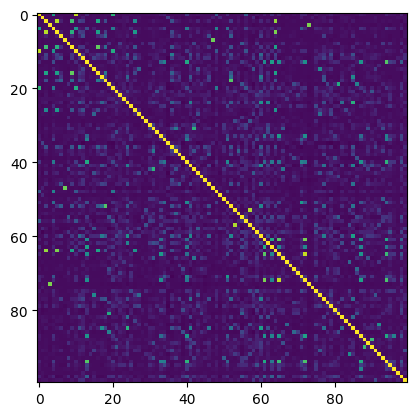

In [21]:
correlations = train_data[:, ids[:100]].T@train_data[:, ids[:100]]
plt.imshow(correlations.cpu())

In [22]:
finetune_ids = []
for ind in ids[:100]:
    independent = True
    for ft_id in finetune_ids:
        corr = (train_data[:, ind]@train_data[:, ft_id])/len(train_data)
        print(text[ind], text[ft_id], corr)
        if corr > 0.5:
            independent = False
    if independent:
        finetune_ids.append(ind)
    if len(finetune_ids) > 4:
        break
print([text[id] for id in finetune_ids])

anglo researcher tensor(-0.0049, device='cuda:0')
wed researcher tensor(-0.0008, device='cuda:0')
wed anglo tensor(-0.0065, device='cuda:0')
ducks researcher tensor(-0.0038, device='cuda:0')
ducks anglo tensor(-0.0052, device='cuda:0')
ducks wed tensor(-0.0028, device='cuda:0')
practitioner researcher tensor(0.5330, device='cuda:0')
practitioner anglo tensor(-0.0064, device='cuda:0')
practitioner wed tensor(0.0052, device='cuda:0')
practitioner ducks tensor(-0.0050, device='cuda:0')
wedding researcher tensor(-0.0017, device='cuda:0')
wedding anglo tensor(-0.0066, device='cuda:0')
wedding wed tensor(0.8908, device='cuda:0')
wedding ducks tensor(-0.0046, device='cuda:0')
victorian researcher tensor(-0.0023, device='cuda:0')
victorian anglo tensor(0.0056, device='cuda:0')
victorian wed tensor(0.0554, device='cuda:0')
victorian ducks tensor(-0.0045, device='cuda:0')
['researcher', 'anglo', 'wed', 'ducks', 'victorian']


## Finetune results

In [23]:
finetune_texts = [text[id] for id in finetune_ids]
finetune_data = train_data[:, finetune_ids]
finetune_data *= train_std[:, finetune_ids]
finetune_data += train_mean[:, finetune_ids]

In [24]:
new_linear = torch.nn.Linear(in_features = finetune_data.shape[1], out_features = 1).to(device)
loss_fn = torch.nn.MSELoss()
#optimizer = torch.optim.SGD(new_linear.parameters(), lr=3e-4)
optimizer = torch.optim.Adam(new_linear.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)

for epoch in range(10000):
    simulated = new_linear(finetune_data)
    loss = loss_fn(simulated, summary_activations)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch%1000==999 or epoch==0:
        print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}')

Epoch: 1, Loss: 0.7920
Epoch: 1000, Loss: 0.2089
Epoch: 2000, Loss: 0.1927
Epoch: 3000, Loss: 0.1891
Epoch: 4000, Loss: 0.1868
Epoch: 5000, Loss: 0.1855
Epoch: 6000, Loss: 0.1849
Epoch: 7000, Loss: 0.1847
Epoch: 8000, Loss: 0.1847
Epoch: 9000, Loss: 0.1847
Epoch: 10000, Loss: 0.1847


In [25]:
print("Loss:{:.4f}".format(loss_fn(simulated, summary_activations)))
corr_coefficient = np.corrcoef(summary_activations[:, 0].cpu(), simulated[:, 0].cpu().detach())[0, 1]
print("Correlation: {:.3f}".format(corr_coefficient))

Loss:0.1847
Correlation: 0.317


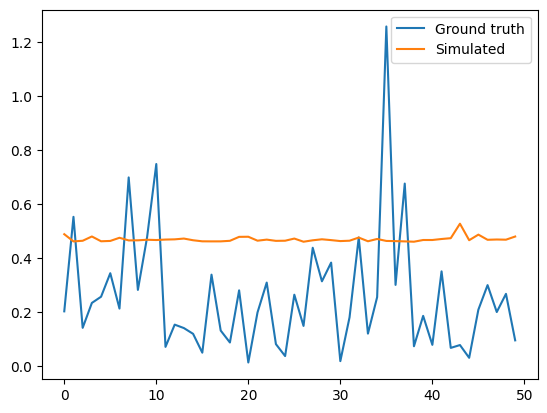

In [26]:
plt.plot(summary_activations[:50].cpu(), label="Ground truth")
plt.plot(simulated[:50].cpu().detach(), label="Simulated")
plt.legend()

y = 0.101x + 0.435


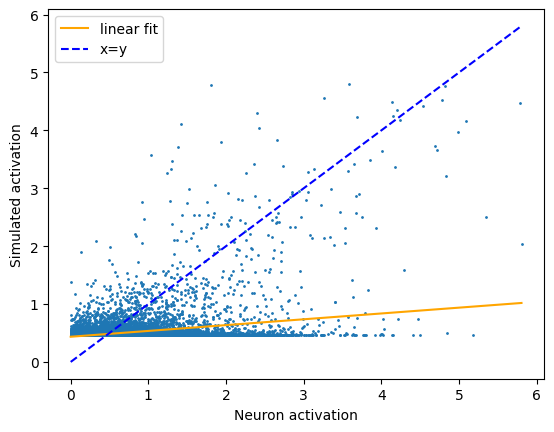

In [27]:
slope, intercept = np.polyfit(summary_activations[:, 0].cpu(), simulated[:,0].cpu().detach(), 1)
print("y = {:.3f}x + {:.3f}".format(slope, intercept))

x = np.array([0.001*i for i in range(int(torch.max(summary_activations)*1000))])
y_fit = slope * x + intercept

plt.scatter(summary_activations.cpu(), simulated.cpu().detach(), s=1)
plt.plot(x, y_fit, color='orange', label="linear fit")
plt.plot(x, x, "b--", label="x=y")
plt.xlabel("Neuron activation")
plt.ylabel("Simulated activation")
plt.legend()

In [28]:
new_vals, new_ids = torch.sort(new_linear.weight[0], descending=True)
print(ids.shape)
for i, id in enumerate(new_ids):
    print(finetune_texts[id], "{:.3f}".format(new_vals[i].cpu()))

torch.Size([18596])
wed 4.730
researcher 4.566
victorian 2.197
anglo 1.187
ducks 1.053


## Old finetune

In [29]:
# non_zero_ids = torch.nonzero(W_g[0])[:, 0]
# non_zero_ids.shape

In [30]:
# finetune_texts = [text[id] for id in non_zero_ids]
# finetune_data = train_data[:, non_zero_ids]

In [31]:
# def smooth_norm(tensor, p=0.5, cutoff=0.001):
#     """
#     let p < 1
#     everything below cutoff will return (1/cutoff*x)^(1/p)
#     everything above cutoff will return (1/cutoff*x)^(p)
#     """
#     tensor = (1/cutoff)*torch.abs(tensor)
#     tensor = torch.min(tensor.pow(p), tensor.pow(1/p))
#     return cutoff*torch.sum(tensor)

# p = 0.1

# new_linear = torch.nn.Linear(in_features = finetune_data.shape[1], out_features = 1).to(device)
# print("Norm: ", smooth_norm(new_linear.weight, p=p))
# loss_fn = torch.nn.MSELoss()
# #optimizer = torch.optim.SGD(new_linear.parameters(), lr=3e-4)
# optimizer = torch.optim.Adam(new_linear.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-8)

# BETA = 2

# for epoch in range(10000):
#     simulated = new_linear(finetune_data)
#     loss = loss_fn(simulated, summary_activations) + BETA*smooth_norm(new_linear.weight, p=p)
    
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     if epoch%1000==999 or epoch==0:
#         print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}')

In [32]:
# print("Non-zero weights:{}".format(torch.sum(new_linear.weight>1e-3)))
# print("Loss:{:.4f}".format(loss_fn(simulated, summary_activations)))
# corr_coefficient = np.corrcoef(summary_activations[:, 0].cpu(), simulated[:, 0].cpu().detach())[0, 1]
# print("Correlation: {:.3f}".format(corr_coefficient))

In [33]:
# new_linear.weight.data *= (new_linear.weight>1e-3)
# simulated = new_linear(finetune_data)
# print("Loss:{:.4f}".format(loss_fn(simulated, summary_activations)))
# corr_coefficient = np.corrcoef(summary_activations[:, 0].cpu(), simulated[:, 0].cpu().detach())[0, 1]
# print("Correlation: {:.3f}".format(corr_coefficient))

In [34]:
# plt.plot(summary_activations[:50].cpu(), label="Ground truth")
# plt.plot(simulated[:50].cpu().detach(), label="Simulated")
# plt.legend()

In [35]:
# slope, intercept = np.polyfit(summary_activations[:, 0].cpu(), simulated[:,0].cpu().detach(), 1)
# print("y = {:.3f}x + {:.3f}".format(slope, intercept))

# x = np.array([0.001*i for i in range(int(torch.max(summary_activations)*1000))])
# y_fit = slope * x + intercept

# plt.scatter(summary_activations.cpu(), simulated.cpu().detach(), s=1)
# plt.plot(x, y_fit, color='orange', label="linear fit")
# plt.plot(x, x, "b--", label="x=y")
# plt.xlabel("Neuron activation")
# plt.ylabel("Simulated activation")
# plt.legend()
# pass

In [36]:
# new_vals, new_ids = torch.sort(new_linear.weight[0], descending=True)
# print(ids.shape)
# for i, id in enumerate(new_ids[:9]):
#     print(finetune_texts[id], "{:.3f}".format(new_vals[i].cpu()))